In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.neighbors import KDTree
from geopy import distance

In [2]:
hats = pd.read_csv("data_gathering/csv_files/hat_all.csv", index_col=0)
guzergahs = pd.read_csv("data_gathering/csv_files/guzergah_all.csv", index_col=0)

In [3]:
guzergahs.ILCEADI.str.upper().sort_values().unique()

array(['ADALAR', 'ARNAVUTKÖY', 'ATASEHIR', 'AVCILAR', 'BAGCILAR',
       'BAHÇELIEVLER', 'BAKIRKÖY', 'BASAKSEHIR', 'BAYRAMPASA', 'BESIKTAS',
       'BEYKOZ', 'BEYLIKDÜZÜ', 'BEYOGLU', 'BÜYÜKÇEKMECE', 'DARICA',
       'ESENLER', 'ESENYURT', 'EYÜPSULTAN', 'FATIH', 'GAZIOSMANPASA',
       'GEBZE', 'GÜNGÖREN', 'KADIKÖY', 'KAGITHANE', 'KARTAL',
       'KÜÇÜKÇEKMECE', 'MALTEPE', 'PENDIK', 'SANCAKTEPE', 'SARIYER',
       'SILE', 'SILIVRI', 'SISLI', 'SULTANBEYLI', 'SULTANGAZI', 'TUZLA',
       'ZEYTINBURNU', 'ÇATALCA', 'ÇAYIROVA', 'ÇEKMEKÖY', 'ÜMRANIYE',
       'ÜSKÜDAR'], dtype=object)

In [4]:
#Normally 25 eu 14 asia but iett has some stops in Kocaeli's districts.
europe_districts = ["ARNAVUTKÖY", "AVCILAR", "BAGCILAR", "BAHÇELIEVLER", "BAKIRKÖY", 
                    "BASAKSEHIR", "BAYRAMPASA", "BESIKTAS", "BEYLIKDÜZÜ", "BEYOGLU", 
                    "BÜYÜKÇEKMECE", "ESENLER", "ESENYURT", "EYÜPSULTAN", "FATIH", 
                    "GAZIOSMANPASA", "GÜNGÖREN", "KAGITHANE", "KÜÇÜKÇEKMECE", "SARIYER",
                    "SILIVRI", "SISLI", "SULTANGAZI", "ZEYTINBURNU", "ÇATALCA"]
print(len(europe_districts))

25


In [5]:
guzergahs["SIDE"] = "ASIA"
guzergahs.loc[guzergahs["ILCEADI"].str.upper().isin(europe_districts), "SIDE"] = "EUROPE"
guzergahs.shape[0], np.sum(guzergahs["SIDE"] == "ASIA"), np.sum(guzergahs["SIDE"] == "EUROPE")

(73018, 34553, 38465)

In [6]:
hatkodu = hats[hats.HAT_DURUMU==1].HAT_KODU.to_numpy()

In [7]:
duraks = guzergahs[['DURAKKODU','DURAKADI','XKOORDINATI','YKOORDINATI','SIDE']].drop_duplicates()

In [8]:
# dk = gpd.GeoSeries.from_wkt(duraks.KOORDINAT)
#dk = gpd.GeoSeries.from_xy(duraks.XKOORDINATI, duraks.YKOORDINATI)

In [9]:
#fig, ax = plt.subplots(1, 1, figsize=(20,10))
#dk.plot(ax = ax, markersize=1)
#plt.show()

In [20]:
# G = nx.DiGraph()
G = nx.Graph()
pos = {kod:(x, y) for kod, x, y in zip(duraks.DURAKKODU, duraks.XKOORDINATI, duraks.YKOORDINATI)}
drk = {kod:durak for kod, durak in zip(duraks.DURAKKODU, duraks.DURAKADI)}
side = {kod:side for kod, side in zip(duraks.DURAKKODU, duraks.SIDE)}

In [21]:
for hat in hatkodu:
    yol = guzergahs[(guzergahs.HATKODU==hat) & (guzergahs.YON=='D')]
    yol = list(zip(yol.SIRANO, yol.DURAKKODU))
    yol = sorted(yol)
    yol = [y[1] for y in yol]
    if len(yol)>1:
        yol = list(zip(yol[:-1], yol[1:]))
        G.add_edges_from(yol)
    
    yol = guzergahs[(guzergahs.HATKODU==hat) & (guzergahs.YON=='G')]
    yol = list(zip(yol.SIRANO,yol.DURAKKODU))
    yol = sorted(yol)
    yol = [y[1] for y in yol]
    if len(yol)>1:
        yol = list(zip(yol[:-1], yol[1:]))
        G.add_edges_from(yol)

In [22]:
def create_contract():
    nodepos = np.asarray([np.asarray(pos[node]) for node in G.nodes])
    tree = KDTree(nodepos)
    contract = []
    for i, node in enumerate(G.nodes):
        close = tree.query([nodepos[i]], k=2)[1][0][1]
        if drk[node] == drk[list(G.nodes)[close]]:
            pair = sorted((node, list(G.nodes)[close]))
            if pair not in contract:
                contract.append(pair)

    print("Node Count: ",len(G.nodes), "\tContract Length: ",len(contract))
    return np.array(contract)

In [23]:
def merge_contract_list(contract):
    contract_count = 0
    for i,(u,v) in enumerate(contract):
        contract_slice = contract[i:]
        contract_mask = (contract_slice[:,0]==v)
        contracted = contract_slice[contract_mask]
        if len(contracted>0):
            # print(contracted)
            # print(i, u, v)
            contract_count += 1
            contract_slice[contract_mask,0] = u
            contract[i:] = contract_slice
    print("Number of contract hits: ", contract_count)
    return contract

In [24]:
def merge_nodes(contract):
    for u,v in contract:
        if u in G.nodes and v in G.nodes:
            nx.algorithms.minors.contracted_nodes(G, u, v, copy=False)
    print("Node Count After Merge: ", len(G.nodes))

In [25]:
while(True):
    print("Creating contract")
    contract = create_contract()
    contract_len = len(contract)
    if(contract_len == 0):
        break
    while(True):
        print("Merging contract")
        contract_merged = merge_contract_list(contract.copy())
        if(np.all(contract == contract_merged)):
            break 
        else:
            contract = contract_merged
    print("Merging nodes")
    merge_nodes(contract)
    print("Removing Self loops")
    print("Before Edge: ", len(G.edges))
    G.remove_edges_from(nx.selfloop_edges(G))
    print("After Edge: ", len(G.edges),"\n")

Creating contract
Node Count:  12463 	Contract Length:  5403
Merging contract
Number of contract hits:  66
Merging contract
Number of contract hits:  3
Merging nodes
Node Count After Merge:  7140
Removing Self loops
Before Edge:  10064
After Edge:  9995 

Creating contract
Node Count:  7140 	Contract Length:  195
Merging contract
Number of contract hits:  4
Merging contract
Number of contract hits:  0
Merging nodes
Node Count After Merge:  6951
Removing Self loops
Before Edge:  9665
After Edge:  9642 

Creating contract
Node Count:  6951 	Contract Length:  18
Merging contract
Number of contract hits:  0
Merging nodes
Node Count After Merge:  6933
Removing Self loops
Before Edge:  9598
After Edge:  9592 

Creating contract
Node Count:  6933 	Contract Length:  1
Merging contract
Number of contract hits:  0
Merging nodes
Node Count After Merge:  6932
Removing Self loops
Before Edge:  9588
After Edge:  9587 

Creating contract
Node Count:  6932 	Contract Length:  0


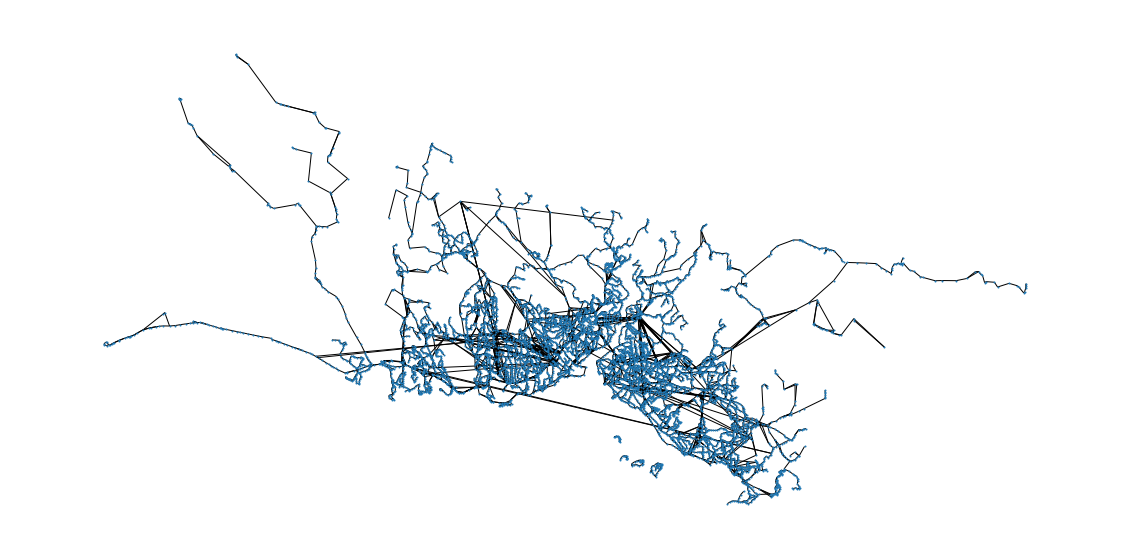

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))
nx.draw(G, pos=pos, node_size=1, ax=ax)
plt.show()

In [15]:
for start,end in G.edges():
    G[start][end]['weight'] = 1 / distance.geodesic(pos[start], pos[end]).kilometers

In [21]:
# Initially took me 13 min
degrees = G.degree()
#betweenness = nx.betweenness_centrality(G, weight='weight')
import json
betweenness = json.load(open('graph_data/betweenness.json'))

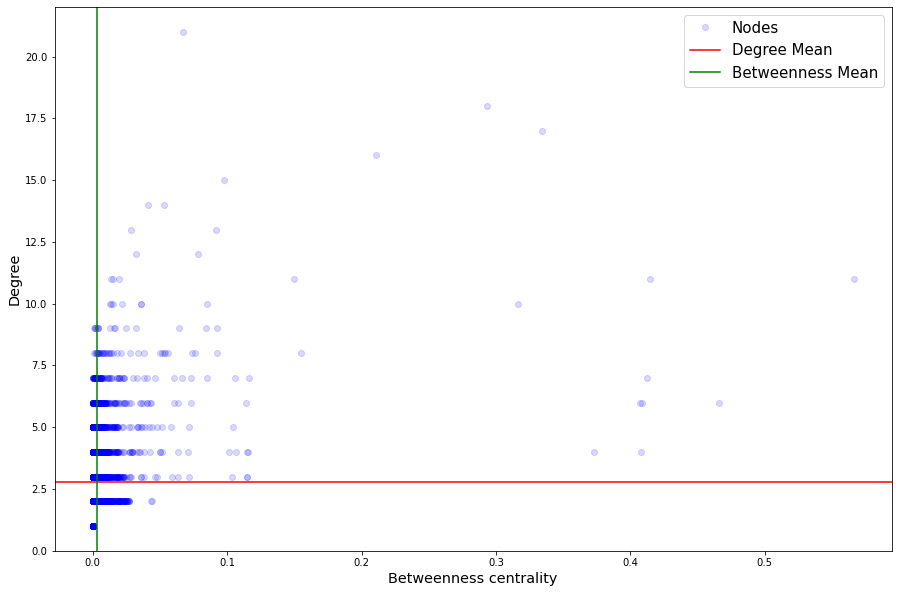

In [35]:
plt.subplots(1, 1, figsize=(15,10))
btw_list = list(betweeness.values())
degree_list = [degree for code,degree in degrees]
plt.plot(btw_list, degree_list, 'ob', alpha=0.15, label="Nodes")
plt.axhline(np.mean(degree_list), c="r", label="Degree Mean")
plt.axvline(np.mean(btw_list), c="g", label="Betweenness Mean")

plt.ylabel(r'Degree', size='x-large')
plt.xlabel(r'Betweenness centrality', size='x-large')
plt.legend(prop={'size': 15})
plt.show()


In [59]:
for node in G.nodes:
    G.nodes[node]["side"] = side[node]

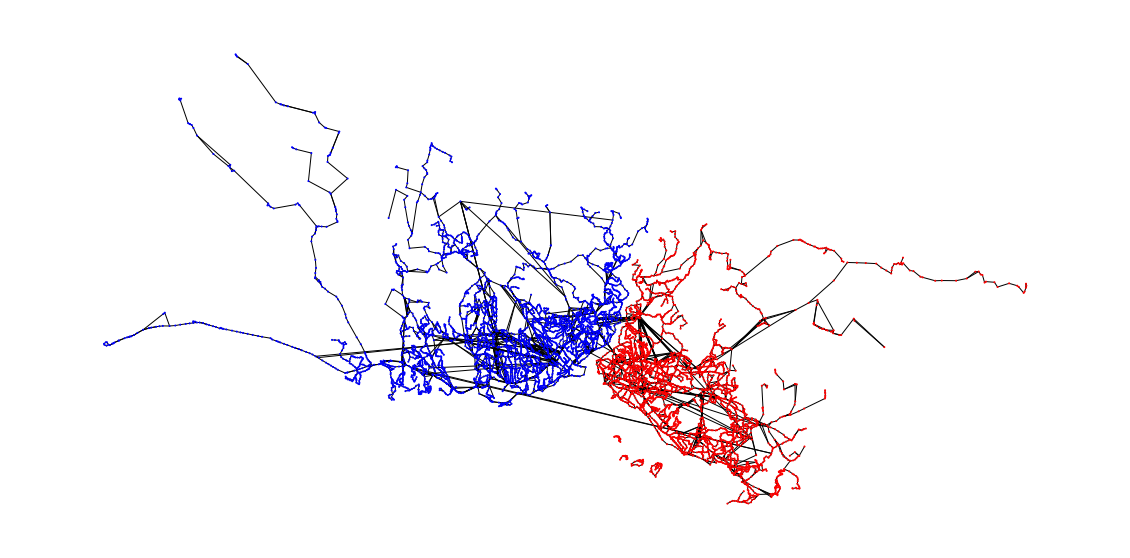

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))
node_color = ["b" if G.nodes[node]["side"]=="EUROPE" else "r" for node in G.nodes]
nx.draw(G, pos=pos, node_size=1, node_color = node_color, ax=ax)
plt.show()

In [60]:
#Create subgraphs
asia_nodes = []
eu_nodes = []
for node in G.nodes:
    if G.nodes[node]["side"] == 'ASIA':
        eu_nodes.append(node)
    else:
        asia_nodes.append(node)

G_ASIA = G.subgraph(asia_nodes)
G_EU = G.subgraph(eu_nodes)

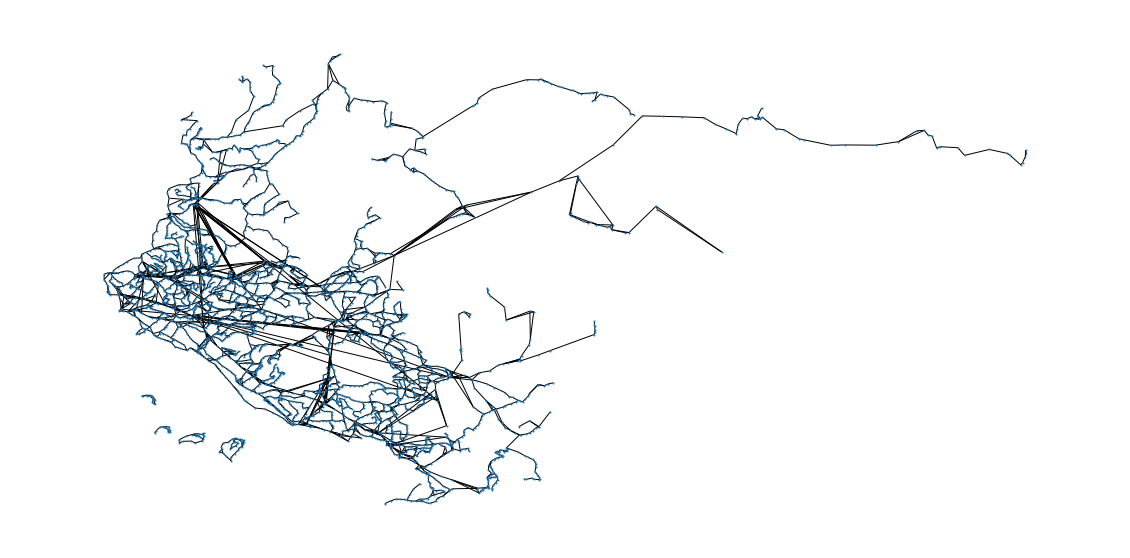

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))
nx.draw(G_EU, pos=pos, node_size=1, ax=ax)
plt.show()

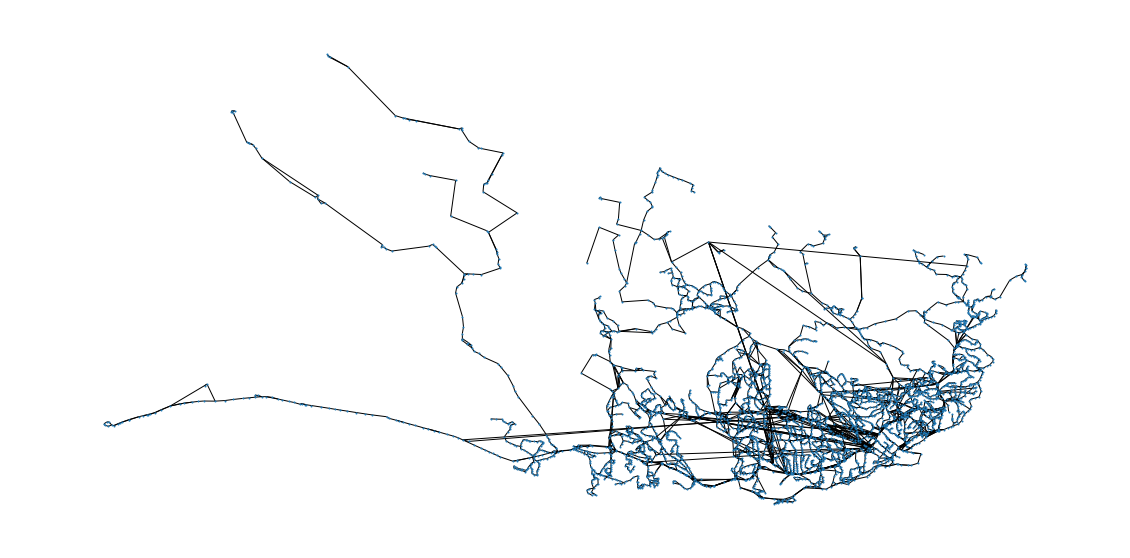

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))
nx.draw(G_ASIA, pos=pos, node_size=1, ax=ax)
plt.show()